In [2]:
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN

from functions import display_scree_plot
from yellowbrick.features import PCA as PCAViz
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [5]:
dataset = pd.read_csv('./clean_dataset.csv', index_col=0)
dataset

,mean_command_price,mean_command_freight_value,articles_per_cart,order_per_client,prefered_payment,mean_review,cancel_ratio,payment_installments,recency,frequency,monetary
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,129.90,12.00,1.0,1.0,credit_card,5.0,0.0,8.0,161,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,8.29,1.0,1.0,credit_card,4.0,0.0,1.0,164,1,18.90
0000f46a3911fa3c0805444483337064,69.00,17.22,1.0,1.0,credit_card,3.0,0.0,8.0,586,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,25.99,17.63,1.0,1.0,credit_card,4.0,0.0,4.0,370,1,25.99
0004aac84e0df4da2b147fca70cf8255,180.00,16.89,1.0,1.0,credit_card,5.0,0.0,6.0,337,1,180.00
...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,497.42,2.0,1.0,credit_card,5.0,0.0,10.0,496,2,1570.00
fffea47cd6d3cc0a88bd621562a9d061,64.89,19.69,1.0,1.0,credit_card,4.0,0.0,1.0,311,1,64.89
ffff371b4d645b6ecea244b27531430a,89.90,22.56,1.0,1.0,credit_card,5.0,0.0,1.0,618,1,89.90


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94720 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mean_command_price          94720 non-null  float64
 1   mean_command_freight_value  94720 non-null  float64
 2   articles_per_cart           94720 non-null  float64
 3   order_per_client            94720 non-null  float64
 4   prefered_payment            94720 non-null  object 
 5   mean_review                 94720 non-null  float64
 6   cancel_ratio                94720 non-null  float64
 7   payment_installments        94720 non-null  float64
 8   recency                     94720 non-null  int64  
 9   frequency                   94720 non-null  int64  
 10  monetary                    94720 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 8.7+ MB


In [6]:
def preprocess(data, nb_category=0):
    """Add features engineering to the dataset"""
    selected_columns = ['recency', 'frequency', 'monetary', 'mean_review']
    cleaned_dataset = data[data['mean_command_freight_value'] != 0]
    categorical_features = cleaned_dataset.select_dtypes(include=['category', 'object']).columns
    dropped_features = categorical_features[nb_category:].append(cleaned_dataset.columns.drop(selected_columns))
    categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    log_features = list(set(['mean_command_price', 'mean_command_freight_value', 'monetary']).intersection(selected_columns))
    log_transformer = Pipeline(steps=[('log', FunctionTransformer(np.log)), ('numeric', numeric_transformer)])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features[:nb_category]),
            ('log', log_transformer, log_features),
            ('dropped', 'drop', dropped_features)
        ],
        remainder=numeric_transformer,
        n_jobs=-1
    )

    preprocessor.fit(cleaned_dataset)
    # new_columns = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)
    # columns = pd.Index(new_columns).append(cleaned_dataset.columns.drop(dropped_features))
    columns = cleaned_dataset.columns.drop(dropped_features)
    return pd.DataFrame(preprocessor.transform(cleaned_dataset), columns=columns)

In [7]:
X = preprocess(dataset)
X

,mean_review,recency,frequency,monetary
0,0.386890,0.677134,-0.830679,-0.281822
1,-1.633089,-0.076298,-0.811105,-0.281822
2,-0.276087,-0.829730,1.942355,-0.281822
3,-1.299273,-0.076298,0.533001,-0.281822
4,0.728714,0.677134,0.317683,-0.281822
...,...,...,...,...
94384,2.998383,0.677134,1.355124,0.889043
94385,-0.340443,-0.076298,0.148039,-0.281822
94386,0.001184,0.677134,2.151148,-0.281822
94387,0.259219,0.677134,-0.778481,-0.281822


In [20]:
from sklearn.neighbors import NearestNeighbors
nb_neighbors = 11
nearest_neighbors = NearestNeighbors(n_neighbors=nb_neighbors)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,nb_neighbors-1])
distances

array([ 0.        ,  0.        ,  0.        , ..., 13.48506699,
       16.68132145, 59.79489266])

0.14630828514937483


<Figure size 360x360 with 0 Axes>

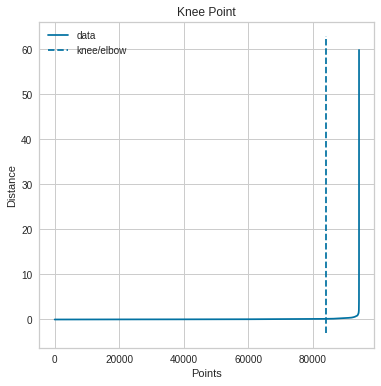

In [23]:
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

13


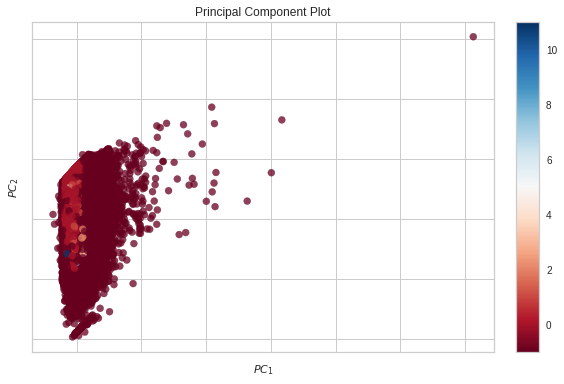

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [29]:
db = DBSCAN(min_samples=100, eps=0.146).fit(X)
print(len(np.unique(db.labels_)))
pca_visualizer = PCAViz(scale=False)
pca_visualizer.fit_transform(X,db.labels_)
pca_visualizer.show()

In [28]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, db.labels_)
score

-0.28715634102087617

In [13]:
from sklearn.cluster import AgglomerativeClustering
X_sample = X.sample(frac=0.1)

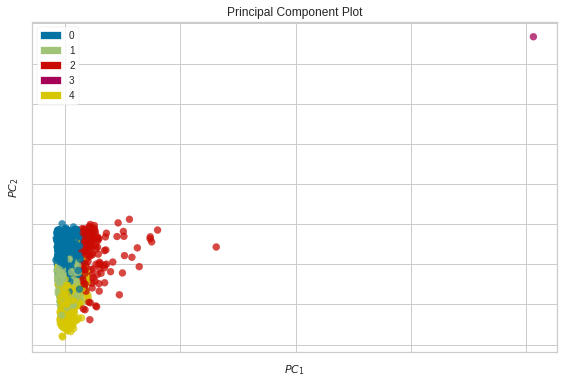

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [15]:
agg = AgglomerativeClustering(n_clusters=5)
agg.fit(X_sample)
pca_visualizer = PCAViz(scale=False)
pca_visualizer.fit_transform(X_sample,agg.labels_)
pca_visualizer.show()

In [16]:

silhouette_visualizer = SilhouetteVisualizer(agg)
silhouette_visualizer.fit(X_sample)
silhouette_visualizer.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

In [35]:
score = silhouette_score(X_sample, agg.labels_)
score

0.23081272472910994

In [238]:
recency = dataset['recency'].reset_index(drop=True)
recency.name = "total_recency"
X_timed = X.merge(recency, left_index=True, right_index=True)

def split_periods(data, periods, time_column="total_recency"):
    """
    Split the dataset into periods based on periods given

        Parameters:
            data (DataFrame): DataFrame to split
            periods (int[]): List of threshold to split on
            time_column (str): Column label containing time info. Default to 'total_recency'

        Returns:
            data_periods (DataFrame[]): A list of DataFrame of the same size as the `periods` input
    """
    data_periods = []
    max_time = data[time_column].max()
    last_threshold = max_time
    for threshold in periods:
        data_periods.append(data[(data[time_column] > max_time - threshold)
                                 & (data[time_column] < last_threshold)])
        last_threshold = max_time - threshold

    return data_periods

periods = split_periods(X_timed, [i*30 for i in range(1, math.ceil(max_time / 30) + 1)][5:])
pd.concat(periods[0:2])

from sklearn.metrics.cluster import adjusted_rand_score

p1 = KMeans(5, random_state=3).fit(periods[0])
p2 = KMeans(5, random_state=3).fit(pd.concat(periods[0:2]))
#p3 = KMeans(5, random_state=3).fit(pd.concat(periods[0:3]))

p1_predict = p1.predict(periods[2])
display(pd.Series(p1_predict).describe())
p2_predict = p2.labels_
display(pd.Series(p2_predict).describe())
#p3_predict = p3.predict(periods[2])
#pd.Series(p3_predict).describe()
print(adjusted_rand_score(p2_predict, p1_predict))

count    2271.0
mean        2.0
std         0.0
min         2.0
25%         2.0
50%         2.0
75%         2.0
max         2.0
dtype: float64

count    5145.000000
mean        2.034208
std         1.598380
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max         4.000000
dtype: float64

ValueError: Found input variables with inconsistent numbers of samples: [5145, 2271]

In [236]:
for i, value in enumerate(periods):
    print(i)
    display(value)

0


,mean_review,recency,frequency,monetary,total_recency
26,-0.422721,-0.076298,2.255545,-0.281822,634
60,-0.615704,-1.583162,2.190297,-0.281822,624
73,0.378792,-0.076298,2.960221,-0.281822,742
134,1.357527,0.677134,1.994553,-0.281822,594
204,0.363148,0.677134,2.085900,-0.281822,608
...,...,...,...,...,...
94195,-1.882286,-2.336594,-0.354370,-0.281822,611
94200,-1.184438,0.677134,0.774418,-0.281822,612
94240,0.259128,0.677134,-1.404860,-0.281822,629
94291,-0.292928,-0.076298,0.213287,-0.281822,622


1


,mean_review,recency,frequency,monetary,total_recency
2,-0.276087,-0.829730,1.942355,-0.281822,586
8,0.427246,-0.076298,1.981504,-0.281822,592
46,-1.345013,-0.829730,1.883632,-0.281822,577
47,0.711042,-0.076298,1.844483,-0.281822,571
86,0.302944,0.677134,1.837958,-0.281822,570
...,...,...,...,...,...
94239,0.981018,-0.076298,-0.856778,-0.281822,573
94271,-0.987373,0.677134,0.011018,-0.281822,582
94311,-1.221211,0.677134,-1.372236,-0.281822,588
94324,0.002233,-0.076298,0.774418,-0.281822,584


2


,mean_review,recency,frequency,monetary,total_recency
27,1.149722,-0.829730,1.655264,-0.281822,542
34,-0.658569,-0.829730,1.687888,-0.281822,547
108,-0.615704,0.677134,1.681363,-0.281822,546
188,0.112654,-2.336594,1.707463,-0.281822,550
199,-0.987373,0.677134,1.772710,-0.281822,560
...,...,...,...,...,...
94124,-0.112468,-0.076298,1.570442,0.889043,553
94150,0.486841,-0.076298,-0.595787,-0.281822,553
94197,0.117986,0.677134,0.291584,-0.281822,536
94212,-0.121209,-0.076298,2.934122,-0.281822,560


3


,mean_review,recency,frequency,monetary,total_recency
64,0.259219,0.677134,1.466046,-0.281822,513
80,-1.744732,0.677134,1.537818,-0.281822,524
211,-1.049351,0.677134,1.407322,-0.281822,504
335,0.057904,0.677134,1.544343,-0.281822,525
385,-1.579060,-0.076298,1.439946,-0.281822,509
...,...,...,...,...,...
94302,-0.894323,0.677134,-0.106428,-0.281822,513
94337,0.662634,0.677134,-0.093378,-0.281822,518
94363,-0.850066,-2.336594,-1.385286,-0.281822,524
94365,1.363898,-1.583162,-0.850253,0.889043,523


4


,mean_review,recency,frequency,monetary,total_recency
28,0.695174,0.677134,1.231153,-0.281822,477
41,-1.345013,-0.076298,1.218104,-0.281822,475
72,-0.426046,0.677134,1.270302,0.889043,483
109,-0.850066,-0.076298,1.355124,-0.281822,496
118,-2.310704,-0.829730,1.322500,-0.281822,491
...,...,...,...,...,...
94269,-0.122389,-0.829730,0.735270,-0.281822,488
94279,-0.422721,-2.336594,-1.287414,-0.281822,494
94348,0.294168,0.677134,1.452996,-0.281822,475
94351,-0.634777,0.677134,-0.732807,-0.281822,499


5


,mean_review,recency,frequency,monetary,total_recency
10,-1.955087,-0.829730,1.100658,-0.281822,457
23,1.260521,-2.336594,1.146331,-0.281822,464
66,0.302944,0.677134,1.074558,-0.281822,453
87,0.833871,0.677134,1.133281,-0.281822,462
182,-0.726347,0.677134,1.028885,-0.281822,446
...,...,...,...,...,...
94280,0.112654,-0.829730,1.857533,-0.281822,467
94313,-0.040186,-0.076298,-1.091670,-0.281822,463
94331,-0.678446,0.677134,-0.830679,0.889043,451
94375,-0.516590,0.677134,-1.293939,-0.281822,459


6


,mean_review,recency,frequency,monetary,total_recency
14,-0.161267,-0.076298,0.944063,-0.281822,433
18,0.984672,-1.583162,0.898389,0.889043,426
29,0.112654,0.677134,0.983211,-0.281822,439
35,-0.639277,-0.076298,0.904914,0.889043,427
70,-0.613815,0.677134,0.826617,-0.281822,415
...,...,...,...,...,...
94225,0.905117,0.677134,-0.745857,-0.281822,426
94266,1.110023,0.677134,-1.059046,-0.281822,415
94278,-0.796315,-0.076298,-0.863303,-0.281822,425
94282,1.029746,0.677134,-0.941600,-0.281822,439


7


,mean_review,recency,frequency,monetary,total_recency
15,-0.261009,0.677134,0.624348,0.889043,384
145,-1.081280,0.677134,0.787468,-0.281822,409
150,0.838600,0.677134,0.728745,-0.281822,400
151,0.784821,0.677134,0.793993,-0.281822,410
161,-0.058288,-0.076298,0.787468,-0.281822,409
...,...,...,...,...,...
94253,0.434517,-2.336594,-0.576212,0.889043,398
94272,-1.750297,0.677134,1.107182,-0.281822,393
94352,-0.613606,-0.076298,1.322500,-0.281822,407
94372,-0.322669,0.677134,-1.137344,2.059908,399


8


,mean_review,recency,frequency,monetary,total_recency
3,-1.299273,-0.076298,0.533001,-0.281822,370
30,0.386890,-2.336594,0.506902,-0.281822,366
56,1.020533,-0.829730,0.441654,0.889043,356
59,0.153658,-0.829730,0.559100,0.889043,374
69,-0.424295,-2.336594,0.428605,-0.281822,354
...,...,...,...,...,...
94221,1.341754,0.677134,2.314268,0.889043,370
94283,0.329609,0.677134,-0.321746,-0.281822,370
94286,0.302944,0.677134,-1.398335,-0.281822,363
94289,0.036711,-0.076298,-1.502732,-0.281822,379


9


,mean_review,recency,frequency,monetary,total_recency
4,0.728714,0.677134,0.317683,-0.281822,337
11,-0.134260,0.677134,0.291584,-0.281822,333
57,-0.850066,-1.583162,0.402505,-0.281822,350
62,0.823233,-2.336594,0.409030,-0.281822,351
84,-0.613815,-1.583162,0.252435,-0.281822,327
...,...,...,...,...,...
94340,0.590579,0.677134,0.161088,-0.281822,332
94342,2.400034,0.677134,0.728745,-0.281822,342
94357,0.890202,0.677134,-1.359187,-0.281822,328
94369,0.211684,0.677134,1.420372,-0.281822,338


10


,mean_review,recency,frequency,monetary,total_recency
16,-1.955087,0.677134,0.134989,-0.281822,309
44,0.002233,0.677134,0.167613,-0.281822,314
54,1.895386,-0.829730,0.134989,0.889043,309
61,-1.383185,0.677134,0.180663,-0.281822,316
96,0.585452,0.677134,0.213287,-0.281822,321
...,...,...,...,...,...
94325,-1.152410,0.677134,-0.922026,-0.281822,310
94328,-1.955087,0.677134,-0.967699,-0.281822,309
94346,0.865000,-0.076298,1.061509,-0.281822,308
94362,0.303818,0.677134,-0.602311,-0.281822,312


11


,mean_review,recency,frequency,monetary,total_recency
17,-1.188057,0.677134,-0.034655,-0.281822,283
31,-0.021200,0.677134,-0.106428,-0.281822,272
55,0.068889,0.677134,-0.028130,-0.281822,284
63,-1.600876,-0.076298,-0.086853,-0.281822,275
79,-1.948324,-0.076298,-0.093378,-0.281822,274
...,...,...,...,...,...
94317,-0.424295,0.677134,0.917964,-0.281822,266
94329,0.230583,0.677134,1.420372,-0.281822,279
94333,0.212637,0.677134,0.239386,-0.281822,275
94376,2.576819,0.677134,-1.176493,5.572502,280


12


,mean_review,recency,frequency,monetary,total_recency
38,-2.033327,-0.829730,-0.334795,-0.281822,237
39,-0.122389,-2.336594,-0.256498,-0.281822,249
67,0.090518,0.677134,-0.178200,-0.281822,261
68,0.035583,-0.076298,-0.282597,-0.281822,245
82,-0.122389,0.677134,-0.184725,-0.281822,260
...,...,...,...,...,...
94344,-0.591211,-0.829730,1.798810,0.889043,236
94354,0.002233,-0.829730,1.002786,-0.281822,234
94364,-0.424295,0.677134,-0.732807,-0.281822,257
94374,-0.058782,0.677134,0.944063,-0.281822,261


13


,mean_review,recency,frequency,monetary,total_recency
7,1.517238,-2.336594,-0.367419,0.889043,232
9,0.162889,-2.336594,-0.445717,-0.281822,220
12,-0.614654,0.677134,-0.524014,-0.281822,208
24,-0.614654,-0.076298,-0.400043,-0.281822,227
53,-0.903956,0.677134,-0.530539,-0.281822,207
...,...,...,...,...,...
94332,-0.122389,-1.583162,-0.086853,-0.281822,207
94349,-0.261009,0.677134,-0.413093,-0.281822,204
94355,1.526143,-0.076298,1.355124,-0.281822,216
94370,-0.987673,0.677134,0.813567,-0.281822,232


14


,mean_review,recency,frequency,monetary,total_recency
5,0.565234,-0.076298,-0.608836,-0.281822,195
6,-1.221585,-0.076298,-0.700183,-0.281822,181
13,-0.340443,-0.076298,-0.719758,-0.281822,178
65,-0.724248,0.677134,-0.647985,-0.281822,189
88,-0.051402,0.677134,-0.582737,-0.281822,199
...,...,...,...,...,...
94335,-2.673940,0.677134,0.252435,-0.281822,184
94339,-1.814215,-0.829730,-1.045997,-0.281822,184
94350,0.909535,-0.076298,-0.139052,-0.281822,192
94359,0.833871,0.677134,-0.256498,-0.281822,196


15


,mean_review,recency,frequency,monetary,total_recency
0,0.386890,0.677134,-0.830679,-0.281822,161
1,-1.633089,-0.076298,-0.811105,-0.281822,164
21,-2.034953,0.677134,-0.895927,-0.281822,151
40,0.605221,0.677134,-0.771956,-0.281822,170
43,-2.410582,0.677134,-0.902452,-0.281822,150
...,...,...,...,...,...
94341,-1.023933,0.677134,-1.346137,0.889043,145
94361,2.039848,-2.336594,2.294693,-0.281822,152
94377,-0.850066,-0.076298,0.807042,-0.281822,167
94378,1.055206,-0.076298,0.037117,0.889043,151


16


,mean_review,recency,frequency,monetary,total_recency
19,0.302070,-0.829730,-1.130819,0.889043,115
45,-0.850066,-0.076298,-1.111245,-0.281822,118
51,-0.860624,-0.829730,-0.980749,-0.281822,138
75,1.425558,0.677134,-1.137344,-0.281822,114
111,-0.338829,-0.829730,-1.013373,-0.281822,133
...,...,...,...,...,...
94316,0.536956,0.677134,0.219811,-0.281822,136
94345,0.002233,-0.076298,1.974979,-0.281822,127
94347,0.515771,-2.336594,1.916256,-0.281822,132
94358,0.465356,0.677134,0.239386,-0.281822,114


17


,mean_review,recency,frequency,monetary,total_recency
22,1.213206,0.677134,-1.333087,3.230772,84
42,0.550846,0.677134,-1.241740,-0.281822,98
52,0.716417,-2.336594,-1.320038,0.889043,86
71,1.830098,0.677134,-1.254790,-0.281822,96
74,-0.724015,0.677134,-1.267840,-0.281822,94
...,...,...,...,...,...
94284,-1.633089,-0.076298,0.728745,-0.281822,95
94287,-2.087506,0.677134,-1.228691,-0.281822,111
94303,-0.532956,0.677134,1.094133,-0.281822,88
94306,-2.300172,0.677134,0.937538,-0.281822,103


18


,mean_review,recency,frequency,monetary,total_recency
20,-1.878074,0.677134,-1.502732,-0.281822,58
32,-0.426046,0.677134,-1.385286,0.889043,76
33,-0.195719,-0.076298,-1.450534,0.889043,66
36,0.441815,-1.583162,-1.528831,0.889043,54
37,-1.458797,0.677134,-1.346137,-0.281822,82
...,...,...,...,...,...
94290,-0.029569,0.677134,2.934122,0.889043,66
94301,-0.264458,0.677134,-0.034655,-0.281822,69
94327,-1.184438,0.677134,-0.876352,-0.281822,65
94360,-0.154348,0.677134,-1.143869,-0.281822,78


19


,mean_review,recency,frequency,monetary,total_recency
487,-1.814215,0.677134,-1.541881,-0.281822,52
649,1.172458,0.677134,-1.548405,-0.281822,51
1530,1.246408,-0.076298,-1.052522,-0.281822,50
2681,0.939002,-0.076298,-0.465291,-0.281822,52
3151,1.743366,-2.336594,-1.333087,2.059908,28
...,...,...,...,...,...
92380,-0.496719,0.677134,-0.354370,-0.281822,52
92757,2.072650,-2.336594,-0.785005,-0.281822,51
93053,-0.634777,-0.076298,0.252435,-0.281822,50
93462,-0.617806,0.677134,1.870582,-0.281822,52


20


,mean_review,recency,frequency,monetary,total_recency
14172,0.192438,0.677134,-1.117770,-0.281822,1
36858,-1.340390,0.677134,0.624348,-0.281822,17
65022,-0.615704,0.677134,1.851008,-0.281822,14
69118,1.072542,0.677134,0.559100,-0.281822,22


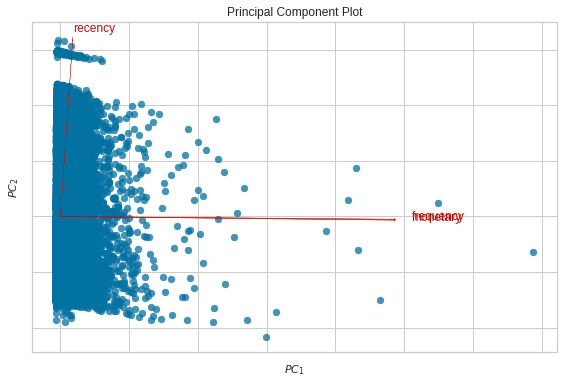

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [13]:
pca_visualizer = PCAViz(proj_features=True, scale=False)
pca_visualizer.fit_transform(X)
pca_visualizer.show()

In [6]:
pca_visualizer.pca_components_

array([[ 0.56889668,  0.61149428,  0.41896213,  0.03124664,  0.06728191,
         0.34842337],
       [-0.21455868,  0.09055118,  0.44590371,  0.09645187,  0.70558641,
        -0.48967315]])

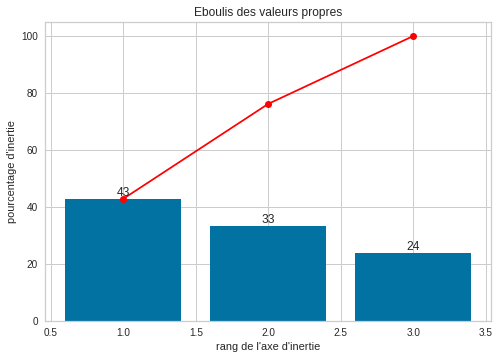

In [14]:
pca = PCA(n_components=len(X.columns))
pca.fit(X)
display_scree_plot(pca)

In [8]:
X_projected = pca.transform(X)
X_projected.shape

(94720, 6)

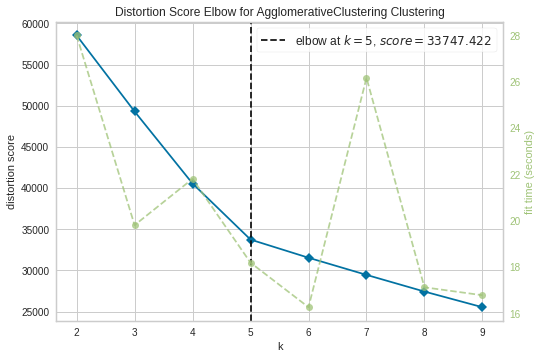

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
visualizer = KElbowVisualizer(agg, k=(2,10))
visualizer.fit(X_sample)
visualizer.show()

In [13]:
visualizer.elbow_value_

5

In [14]:
model = KMeans(visualizer.elbow_value_, random_state=3)
model.fit(X)

KMeans(n_clusters=5, random_state=3)

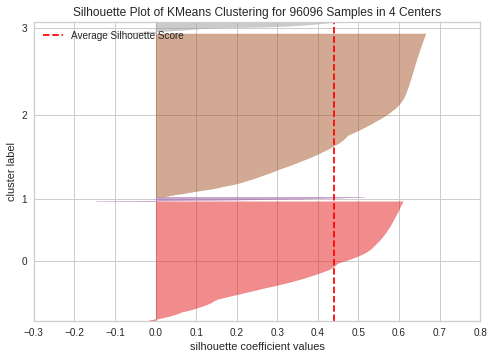

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96096 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
silhouette_visualizer = SilhouetteVisualizer(model)
silhouette_visualizer.fit(X)
silhouette_visualizer.show()

In [15]:
len(silhouette_visualizer.silhouette_samples_)

94720

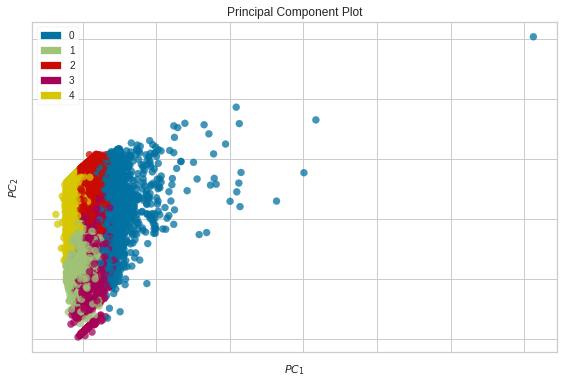

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [17]:
pca_visualizer = PCAViz(scale=False)
pca_visualizer.fit_transform(X,model.labels_)
pca_visualizer.show()

In [52]:
def draw_radar_plot(data, labels, merged=True, nb_columns=2):
    """ Draw a radar plot """
    # centroids = model.cluster_centers_
    scaler = MinMaxScaler()
    # labels = X.columns.values
    # stats = centroids
    stats = scaler.fit_transform(data)

    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the shape
    angles=np.concatenate((angles,[angles[0]]))
    first_stats = np.array([stat[0] for stat in stats]).reshape(-1,1)
    stats = np.append(stats, first_stats, axis=1)

    fig=plt.figure(figsize=(15,15))
    for i, stat in enumerate(stats):
        if merged:
            ax = plt.subplot(polar=True)
        else:
            ax = plt.subplot(nb_columns, math.ceil(len(stats)/nb_columns), i+1, polar=True)
        ax.plot(angles, stat, 'o-', linewidth=2)
        ax.fill(angles, stat, alpha=0.25)
        plt.thetagrids(angles[0:-1] * 180/np.pi, labels)
    fig.suptitle("Clusters stats")
    fig.tight_layout()
    plt.show()


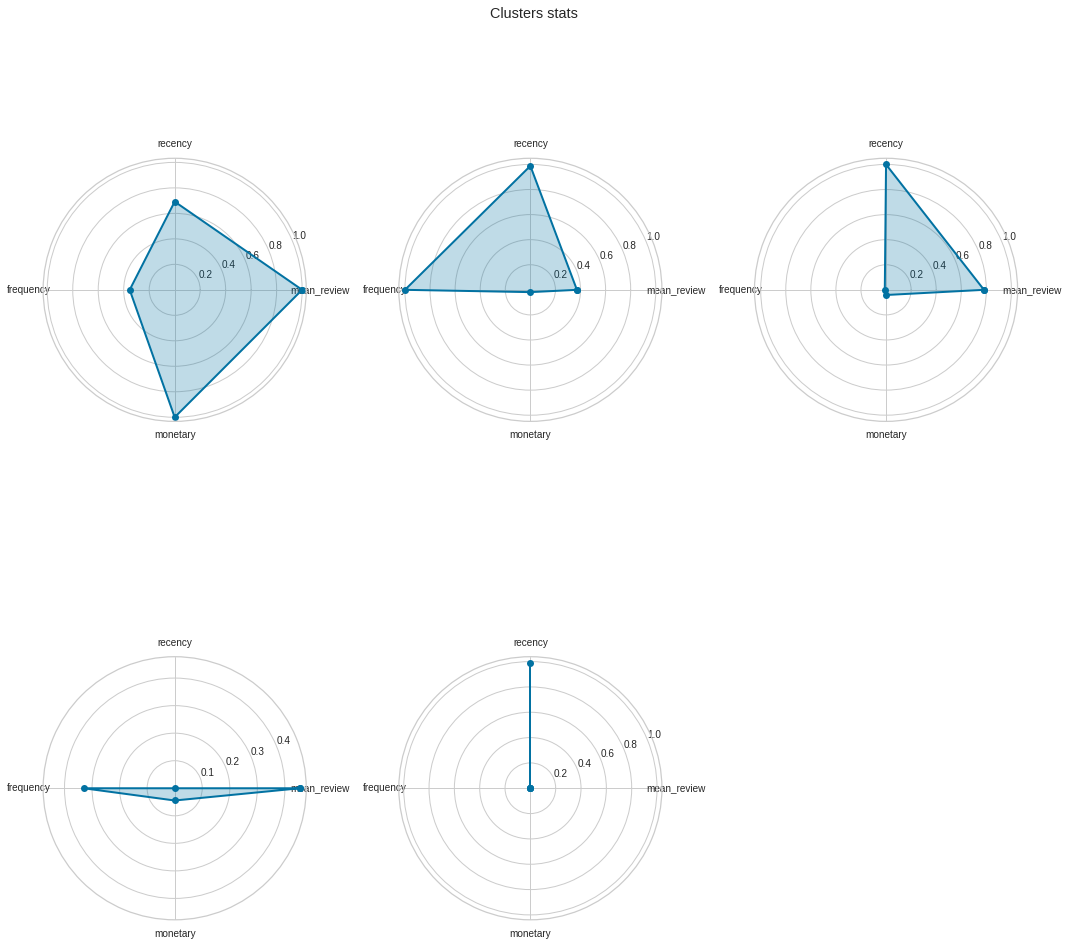

In [53]:
draw_radar_plot(model.cluster_centers_, X.columns.values, merged=False)

In [173]:
labels = pd.Series(model.labels_)
labels.name = 'labels'
X_labeled = X[['recency', 'frequency', 'monetary', 'mean_review']].merge(labels, left_index=True, right_index=True)

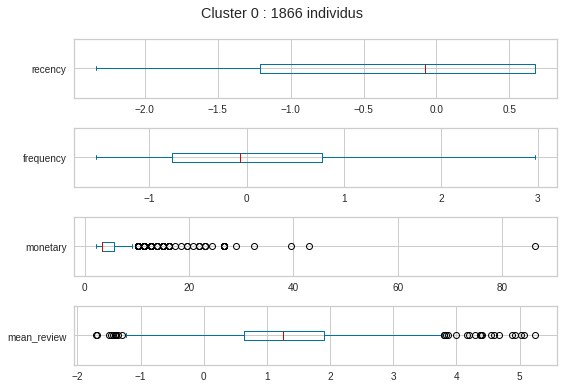

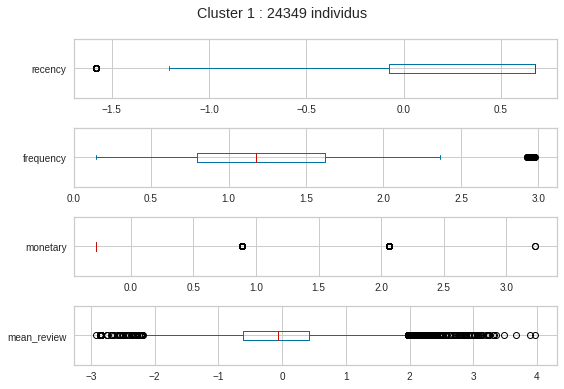

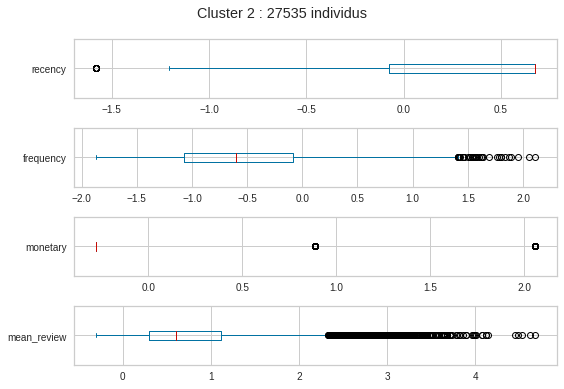

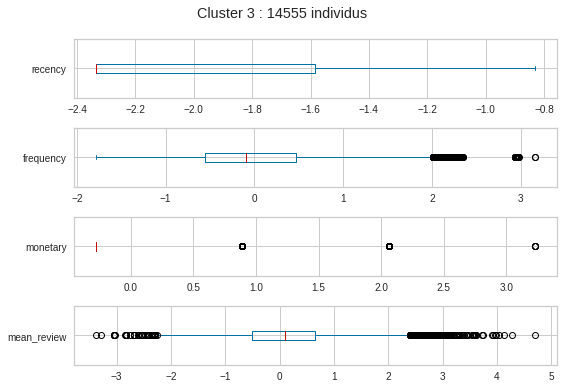

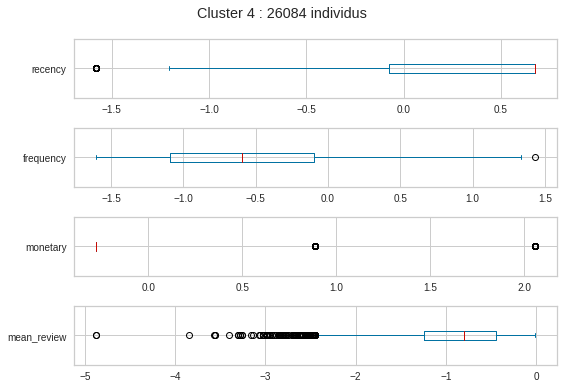

In [174]:
grouped = X_labeled.groupby('labels')
for i in range(0, model.n_clusters):
    cluster = grouped.get_group(i)
    cluster.drop(columns=['labels']).plot.box(vert=False, subplots=True, layout=(4,1), sharex=False, title=f'Cluster {i} : {cluster.shape[0]} individus')
    plt.tight_layout()
    plt.show()

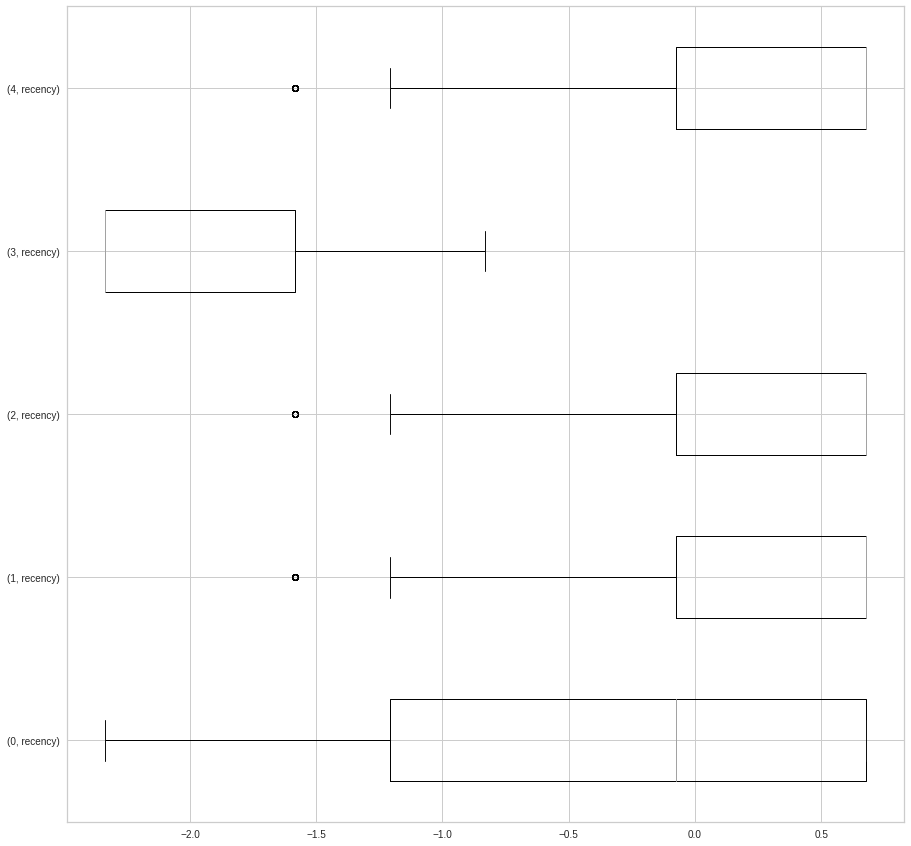

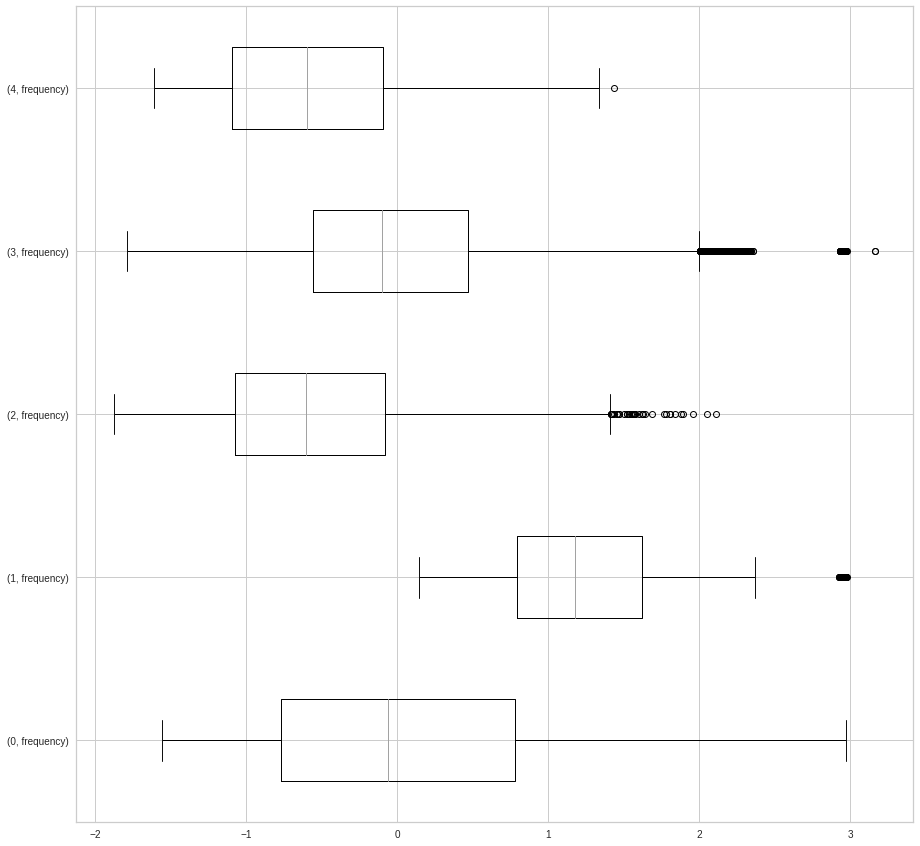

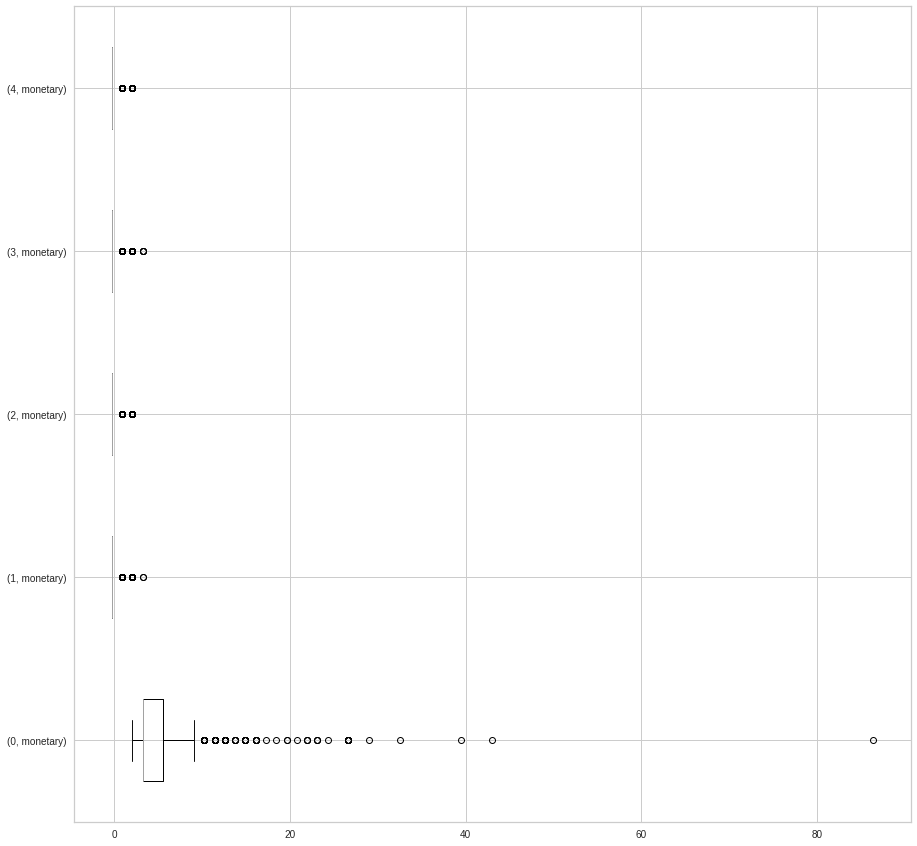

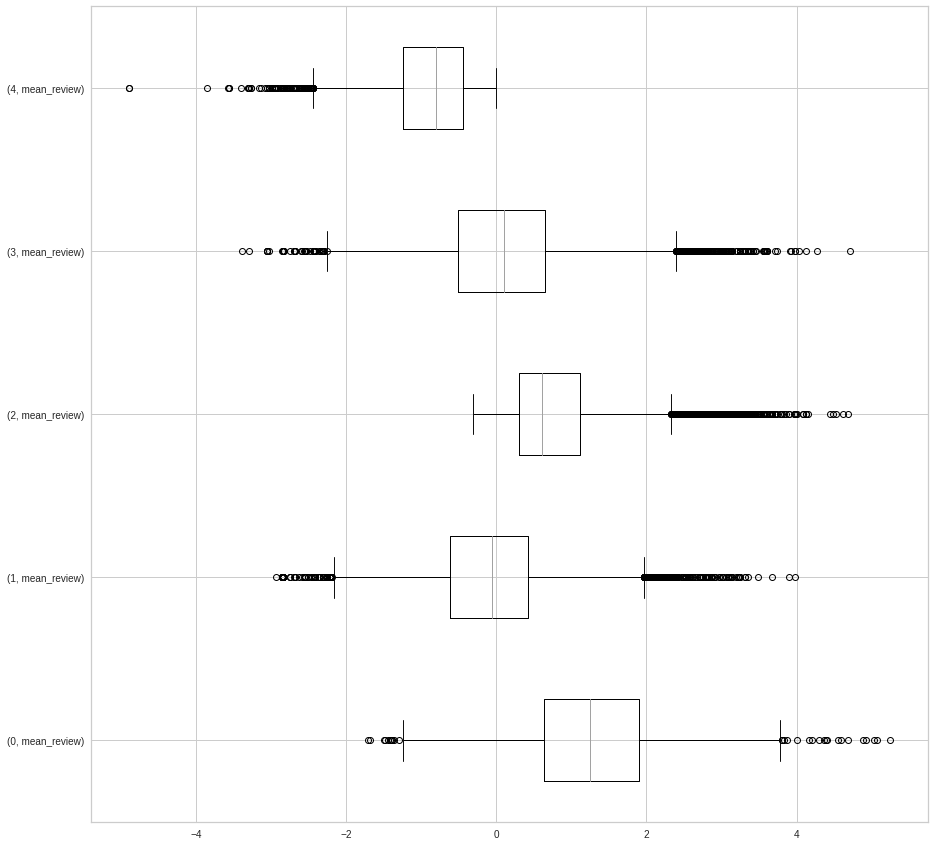

In [177]:
grouped = X_labeled.groupby('labels')

for i in X_labeled.drop(columns=['labels']).columns:
    grouped.boxplot(column=i,figsize=(15,15), vert=False, subplots=False)
    plt.show()


In [171]:
grouped.mean()

,recency,frequency,monetary,mean_review
labels,,,,
0,282.338692,1.299035,153.609411,4.104948
1,288.881227,1.238942,148.845309,4.110794
2,289.321918,1.240094,149.971178,4.110328
3,286.164067,1.239780,148.751437,4.077617
4,286.716071,1.237809,148.892442,4.099739


In [172]:
model.cluster_centers_

array([[ 1.26584572, -0.34053434,  0.06144733,  4.90236037],
       [-0.091616  ,  0.37189523,  1.22419868, -0.12824525],
       [ 0.79396813,  0.39994841, -0.55527255, -0.01089931],
       [ 0.08900978, -2.00495915,  0.02151888,  0.00532441],
       [-0.89290904,  0.37396677, -0.573195  , -0.22247269]])

In [77]:
dataset['label'] = model.labels_
dataset['label'].value_counts()

/home/jbrichardet/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0    59296
1    24788
3     7427
2     2878
Name: label, dtype: int64

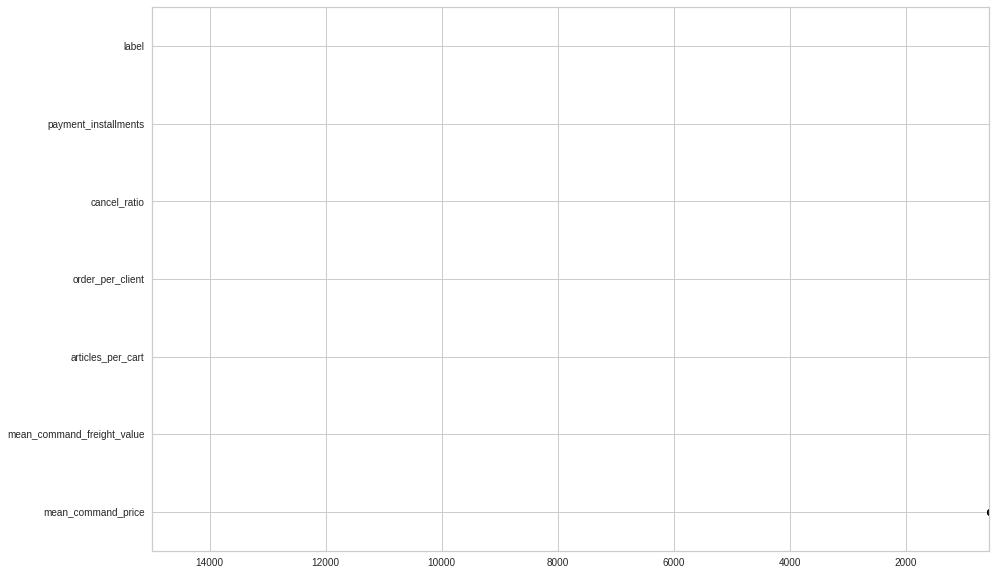

In [94]:
ax = dataset[dataset['label'] == 0].boxplot(vert=False, figsize=(15,10))
ax.set_xlim(15000)
plt.show()

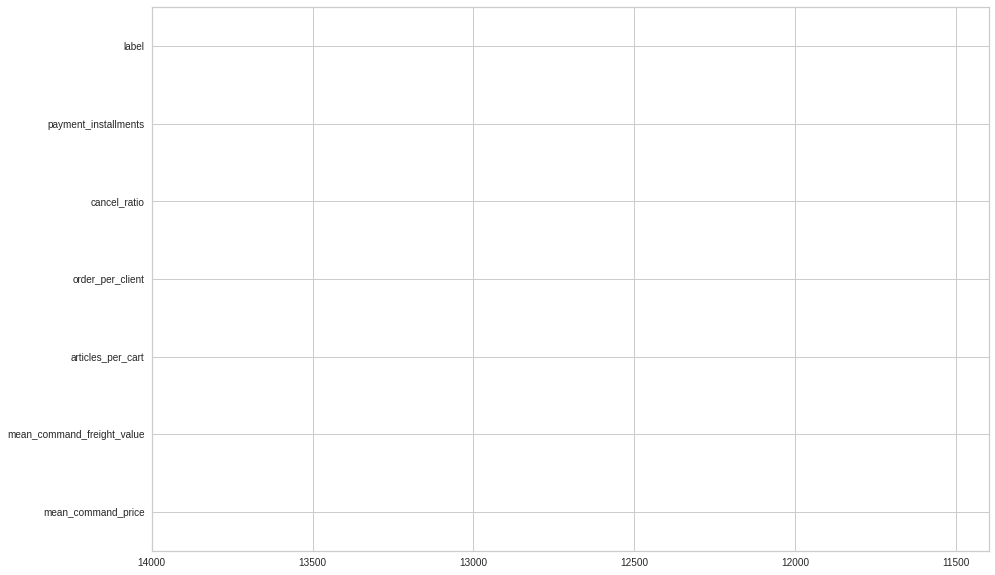

In [95]:
ax = dataset[dataset['label'] == 1].boxplot(vert=False, figsize=(15,10))
plt.show()

<AxesSubplot:>

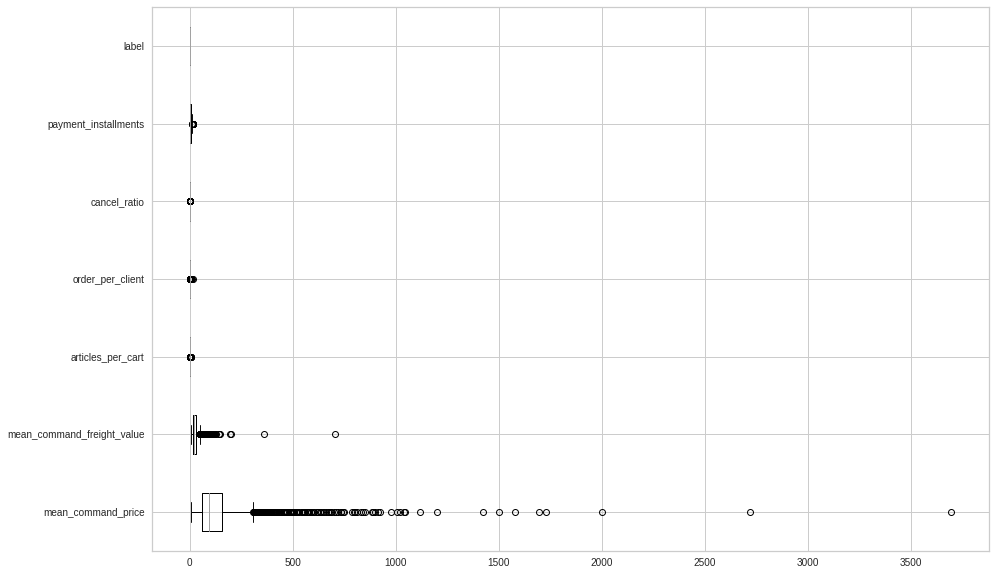

In [92]:
dataset[dataset['label'] == 2].boxplot(vert=False, figsize=(15,10))

<AxesSubplot:>

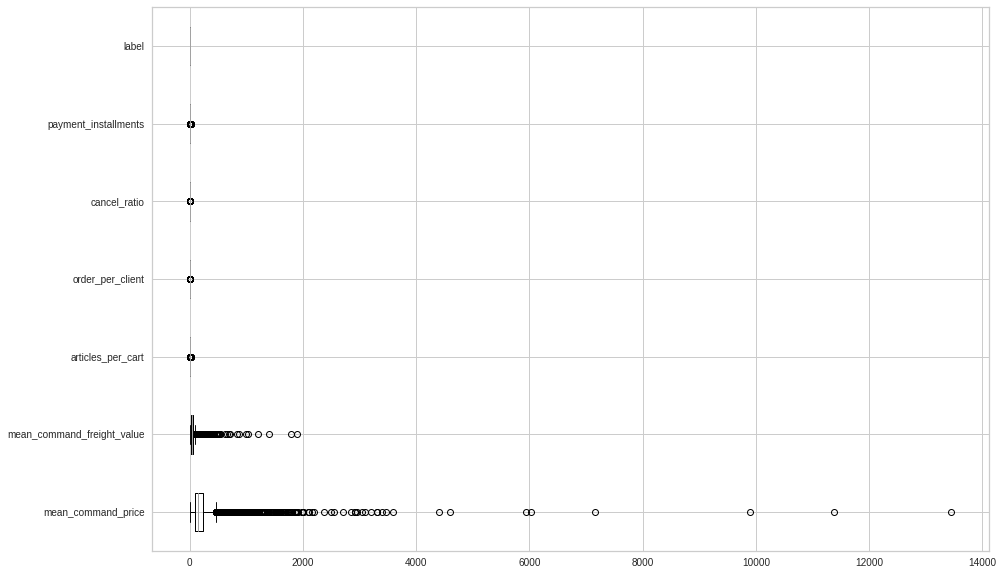

In [93]:
dataset[dataset['label'] == 3].boxplot(vert=False, figsize=(15,10))

# TODO
* Qualifier chaque cluster pour le marketing

## Analyse temporelle
* Se baser sur la récence (sans Scaler) et diviser en périodes régulières avec une première plus longue. i.e.: P1 = 6mois et les autres 1 mois
* Entrainer le modele P1, calcul ARI sur P2
* Entrainer le model sur P1+P2, calcul ARI sur P2
* Entrainer le model sur P1+P2+...+Pn, calcul ARI sur Pn
* Utiliser le model P1 pour prédire sur P2, puis P1+P2 pour prédire P2, et calculer ARI score sur P2
* Si le ARI score chute, les clusters sont très differents entre deux périodes. Le modèle est donc démodé, il faut le mettre à jour
* Tracer un graphe avec les P en x et les ARI en y, une ligne brisée par model (modele P1, modele P1+P2,..)

In [3]:
for scale, log in [(False, False), (False, True), (True, False), (True, True)]:

    print(f'/{"Std " if scale else ""}{"Log " if log else ""}silhouttes.png')


/silhouttes.png
/Log silhouttes.png
/Std silhouttes.png
/Std Log silhouttes.png
